# What this project is about
As a broad racial category, Asian Americans are the fastest-growing minority group in the United States (U.S. Census Bureau, 2012).
The city of Texas has conducted the Asian American Quality of Life Survey and published the data. This project aims to analyze the data and develop models to predict the quality of life. 

There is a "Quality of Life" column in the data, where the sample person's quality of life rating (0-10) is entered. In model devloping, the rating was divided into two categories, "high (8-10)" and "not high (0-7)," .  After taht, I constructed models to predict it.

Type of learning : Supervised learning, Unsupervised learning<br>
Type of task     : Binary classification


# Data source
Data source name : Final Report of the Asian American Quality of Life (AAQoL)<br>
                   https://catalog.data.gov/dataset/final-report-of-the-asian-american-quality-of-life-aaqol

Data column definition : https://www.opendatanetwork.com/dataset/data.austintexas.gov/hc5t-p62z

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings

from sklearn.decomposition import NMF
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [2]:
df = pd.read_csv('Final_Report_of_the_Asian_American_Quality_of_Life__AAQoL_.csv')

# About the data

Data has 231 columns. (Moderately large number of columns)

In [3]:
df.head()

,Survey ID,Age,Gender,Ethnicity,Marital Status,Education Completed,Household Size,No One,Spouse,Children,...,Other Description (Non-city-based Ethnic),Paper (Non-city-based General),TV/Radio (Non-city-based General),Website (Non-city-based General),Social Networks (Non-city-based General),People (Non-city-based General),Other (Non-city-based General),Other Description (Non-city-based General),Preferred Type,Concerns
0,80314,NaN,NaN,Vietnamese,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60171,60.0,Male,Chinese,Married,13.0,6.0,0,0,Living with children,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1011601,23.0,Female,Chinese,Single,16.0,3.0,0,0,0,...,NaN,No,No,No,No,Yes,No,NaN,email,traffic
3,50046,73.0,Female,Chinese,Other,13.0,1.0,Living with no one,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10494,29.0,Male,Asian Indian,Single,17.0,1.0,Living with no one,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>
There are only 2609 data items and many columns that have null-value.

In [4]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(2609, 231)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Columns: 231 entries, Survey ID to Concerns
dtypes: float64(40), int64(1), object(190)
memory usage: 4.6+ MB
None
Survey ID                                        0
Age                                              9
Gender                                          27
Ethnicity                                        2
Marital Status                                  18
                                              ... 
People (Non-city-based General)                 52
Other (Non-city-based General)                  54
Other Description (Non-city-based General)    2595
Preferred Type                                 575
Concerns                                      1307
Length: 231, dtype: int64


<br>
The "Income" field containes Nan-value data and monetary range data. So python cannot be treated it as numerical data as it is. Therefore, I deleted Nan-value data, and in the case of monetary range data, I took average to convert it to numerical value.

In [5]:
df['Income'].head()

0                  NaN
1    $30,000 - $39,999
2          $0 - $9,999
3                  NaN
4                  NaN
Name: Income, dtype: object

In [6]:
df = df.dropna(subset=['Income'])
k = []

for i in range(len(df['Income'])):
    j = df.iloc[i]['Income']
    j = j.replace(",","")
    k.append(re.findall(r'\d+', j))

for h in range(len(df['Income'])):
    k[h] = [int(s) for s in k[h]]
    k[h] = np.mean(k[h])
    
df['Income_new'] = k
df[['Income','Income_new']].head(10)
df = df.drop('Income', axis=1)

df['Income_new'].head()

1    34999.5
2     4999.5
6    70000.0
7    70000.0
8    54999.5
Name: Income_new, dtype: float64

<br>
Data conversion to divide Quality of Life into two values, high and not high, was also performed. In addition, the NA rows were deleted.

In [7]:
q = []

df = df.dropna(subset=['Quality of Life'])

for i in range(len(df['Quality of Life'])):
    j = int(df.iloc[i]['Quality of Life'])
    if j >= 8:
        q.append(1)
    else:
        q.append(0)

df['Quality of Life_High'] = q
df[['Quality of Life','Quality of Life_High']].head(10)

,Quality of Life,Quality of Life_High
2,8.0,1
6,8.0,1
8,10.0,1
9,9.0,1
11,6.0,0
12,8.0,1
13,8.0,1
14,7.0,0
15,5.0,0
17,8.0,1


# Exploratory Data Analysis(EDA)
## Part1（Histgram,scatter plot)
I took a histogram of quality of life for each ethnicity to see the data characteristics. It seems that there are differences by ethnicity, with many Chinese and Indians having a relatively high quality of life. 

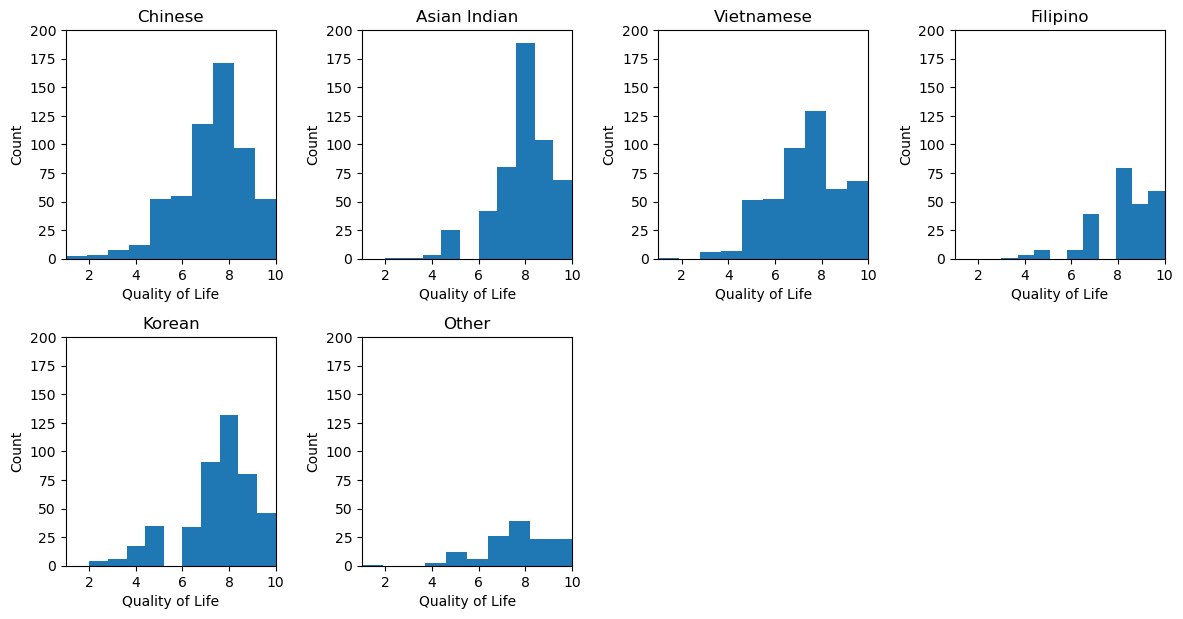

In [8]:
warnings.simplefilter('ignore')

eth = df['Ethnicity'].unique()

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,1,1)
i = 0

for e in eth: 
    ax1 = plt.subplot2grid((4, 4), (i//4, i%4))
    x = df['Quality of Life'][df['Ethnicity'] == e]
    ax1.hist(x)
    plt.ylim(0,200)
    plt.xlim(1,10)
    ax1.set_title(e)
    ax1.set_xlabel('Quality of Life')
    ax1.set_ylabel('Count')
    i = i + 1
plt.tight_layout()
plt.show()

<br>
I also took a histogram of quality of life for each occupation to see the data characteristics. It also seems that there are differences by occupation.

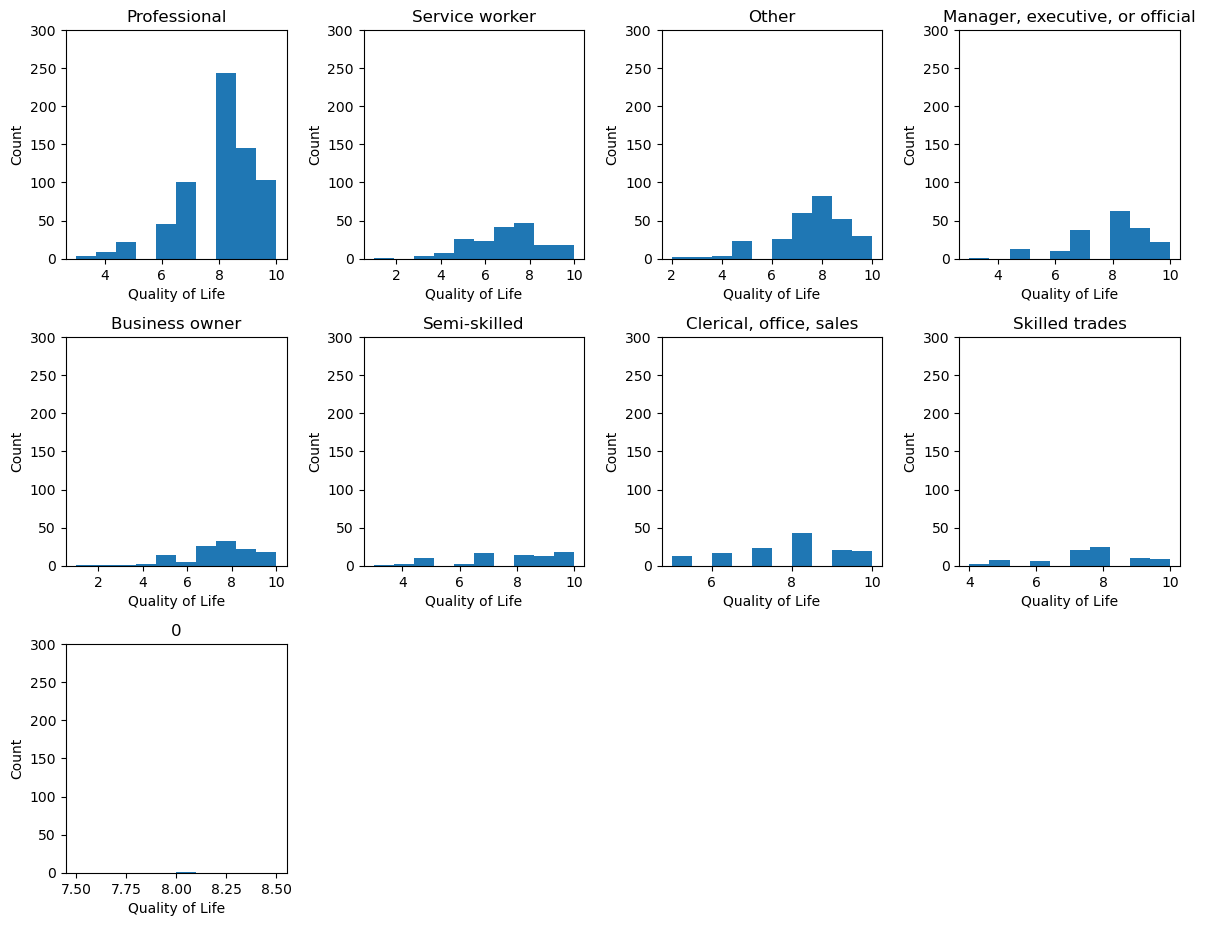

In [9]:
warnings.simplefilter('ignore')

df = df.dropna(subset=['Occupation'])
ocu = df['Occupation'].unique()

fig = plt.figure(figsize=(12,12))
ax2 = fig.add_subplot(1,1,1)
i = 0

for o in ocu: 
    ax2 = plt.subplot2grid((4, 4), (i//4, i%4))
    x = df['Quality of Life'][df['Occupation'] == o]
    ax2.hist(x)
    plt.ylim(0,300)
    ax2.set_title(o)
    ax2.set_xlabel('Quality of Life')
    ax2.set_ylabel('Count')
    i = i + 1
plt.tight_layout()
plt.show()

<br>
On the other hand, the relevance between income and quality of life could not be confirmed from the scatter plots.

<AxesSubplot: xlabel='Income_new', ylabel='Quality of Life'>

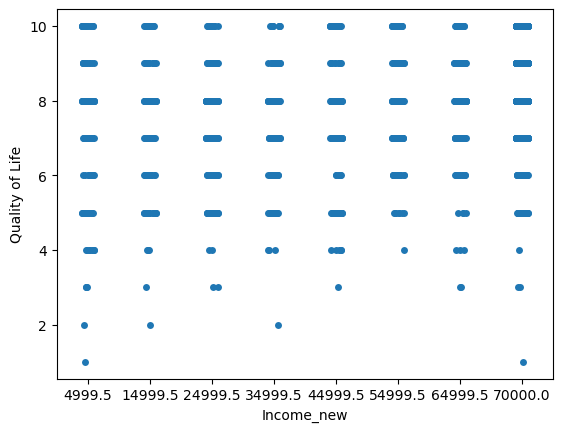

In [10]:
sns.stripplot(x="Income_new", y="Quality of Life", data=df)

## Part2（Correlation)
I calculated correlation coefficients of all items vs quality of life.<br>
The top three most correlated items are as follows:<br>
・1）Comunication Problem<br>
・2）Income_new<br>
・3）Interpretaion(Medical)<br>
-> Income was highly correlated with quality of life, although I did not confirm this by the scatterplot. Intuitively, I think it is right.

In [11]:
columns = df.columns.values
print(columns)

['Survey ID' 'Age' 'Gender' 'Ethnicity' 'Marital Status'
 'Education Completed' 'Household Size' 'No One' 'Spouse' 'Children'
 'Grand Children' 'Parent' 'Grandparent' 'Brother/Sister' 'Other Relative'
 'Friends' 'Other ' 'Other Description' 'Religion' 'Religion Other'
 'Full Time Employment' 'Part Time Employment' 'Self Employed Full Time'
 'Self Employed Part Time' 'Student' 'Homemaker' 'Disabled' 'Unemployed'
 'Retired' 'Other Employement' 'Other Employment Description' 'Occupation'
 'Occupation Other' 'Achieving Ends Meet' 'US Born'
 'Duration of Residency' 'Primary Language' 'English Speaking'
 'English Difficulties' 'Familiarity with America'
 'Familiarity with Ethnic Origin' 'Identify Ethnically' 'Belonging'
 'Discrimination ' 'Present Health' 'Present Mental Health'
 'Present Oral Health' 'Hygiene Assistance' 'Smoking' 'Drinking'
 'Regular Exercise' 'Healthy Diet' 'Hypertension' 'Heart Disease' 'Stroke'
 'Diabetes' 'Cancer' 'Arthritis' 'Hepatitis' 'Kidney Problem' 'Asthma'
 'COP

In [12]:
le = LabelEncoder()

r = []
s1 = pd.Series(df['Quality of Life_High'])
df_original = df

for c in columns: 
    if df[c].dtype == object:
        df[c] = le.fit_transform(df[c])
    df = df.dropna(subset=[c])
    s2 = pd.Series(df[c])
    if not np.isnan(s1.corr(s2)):
        r.append([abs(s1.corr(s2)), c])
    else:
        print(s1.corr(s2), c)

print('-'*80)


r.sort(reverse=True, key=lambda x:x[0])
count = 0
for a in r:
    print(a)
    count += 1
print(count)

nan Grandparent
nan Other Relative
nan Other 
nan Other Description
nan Self Employed Full Time
nan Self Employed Part Time
nan Disabled
nan Unemployed
nan Other Employement
nan Other Employment Description
nan Heart Disease
nan Stroke
nan Cancer
nan Hepatitis
nan Kidney Problem
nan Asthma
nan COPD
nan Psychiatrist
nan Therapist/Counselor 
nan Other Transportation Description
--------------------------------------------------------------------------------
[1.0, 'Quality of Life_High']
[0.7953196416739948, 'Quality of Life']
[0.24036391062046206, 'Comunication Problem']
[0.23864688960015376, 'Income_new']
[0.2362006567463089, 'Interpretation (Medical)']
[0.2114093808545553, 'Satisfaction With Housing.']
[0.20495608868936327, 'Education Completed']
[0.20387549676580743, 'Family Pride']
[0.19752728998335312, 'Place to Live']
[0.19274570619149112, 'Preferance']
[0.1891598983001188, 'Achieving Ends Meet']
[0.18809050770776659, 'Place to Work']
[0.18391470962635878, 'Regular Exercise']
[0.18

<br>
In order to calculate the accuracy scores for each number of variables in subsequent modeling, I made a list for each number of variables.

In [13]:
columns2 = [[] for i in range(20)]

for i in range(2,22):
    for j in range(0,20):
        if j >= i-2:
            columns2[j].append(r[i][1])
print(columns2)

for j in range(0,20):
    columns2[j].append( 'Quality of Life_High')
    

[['Comunication Problem'], ['Comunication Problem', 'Income_new'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.', 'Education Completed'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.', 'Education Completed', 'Family Pride'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.', 'Education Completed', 'Family Pride', 'Place to Live'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.', 'Education Completed', 'Family Pride', 'Place to Live', 'Preferance'], ['Comunication Problem', 'Income_new', 'Interpretation (Medical)', 'Satisfaction With Housing.', 'Education Completed', 'Family Pride', 'Place to Live', 'Preferance', 'Achieving Ends Meet

<br>
The correlation matrix of the top 10 most correlated items plus quality of life is as follows

<AxesSubplot: >

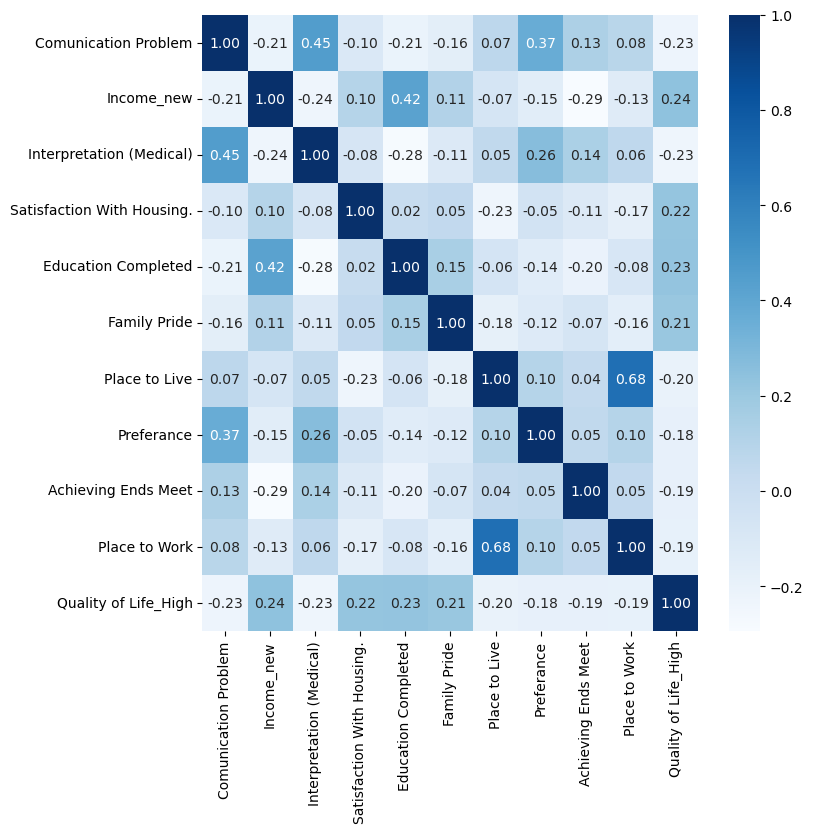

In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[columns2[9]].corr(), annot=True, fmt='.2f', cmap='Blues') 

<br>
Because too much data were deleted to calculate correlations for all items, Nan-value data exclusion and labeling were performed again with only the necessary items.

In [15]:
df[columns2[9]].info()
df[columns2[9]].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 64 to 2602
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Comunication Problem        971 non-null    int32  
 1   Income_new                  971 non-null    float64
 2   Interpretation (Medical)    971 non-null    int32  
 3   Satisfaction With Housing.  971 non-null    int32  
 4   Education Completed         971 non-null    float64
 5   Family Pride                971 non-null    int32  
 6   Place to Live               971 non-null    int32  
 7   Preferance                  971 non-null    int32  
 8   Achieving Ends Meet         971 non-null    float64
 9   Place to Work               971 non-null    int32  
 10  Quality of Life_High        971 non-null    int64  
dtypes: float64(3), int32(7), int64(1)
memory usage: 96.8 KB


,Comunication Problem,Income_new,Interpretation (Medical),Satisfaction With Housing.,Education Completed,Family Pride,Place to Live,Preferance,Achieving Ends Meet,Place to Work,Quality of Life_High
64,0,70000.0,0,3,17.0,2,2,0,0.0,0,1
65,1,24999.5,0,2,16.0,0,2,1,0.0,2,0
66,0,70000.0,0,3,17.0,0,2,1,0.0,2,1
78,1,64999.5,0,2,17.0,2,3,1,0.0,2,0
79,1,34999.5,1,2,16.0,3,2,1,0.0,2,1


In [16]:
df_original2 = df_original[columns2[19]] 
columns_oroginal = df_original2.columns.values
le = LabelEncoder()

for c in columns_oroginal: 
    if df_original2[c].dtype == object:
        df_original2[c] = le.fit_transform(df_original2[c])
    df_original2 = df_original2.dropna(subset=[c])

In [17]:
df_original2[columns2[9]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 8 to 2608
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Comunication Problem        1633 non-null   int32  
 1   Income_new                  1633 non-null   float64
 2   Interpretation (Medical)    1633 non-null   int32  
 3   Satisfaction With Housing.  1633 non-null   int32  
 4   Education Completed         1633 non-null   float64
 5   Family Pride                1633 non-null   int32  
 6   Place to Live               1633 non-null   int32  
 7   Preferance                  1633 non-null   int32  
 8   Achieving Ends Meet         1633 non-null   float64
 9   Place to Work               1633 non-null   int32  
 10  Quality of Life_High        1633 non-null   int64  
dtypes: float64(3), int32(7), int64(1)
memory usage: 108.4 KB


# Models
## Part1（Supervised Learning Model - Multiple Model Comparison）
Three types of models were created:<br>
・1）Random forest<br>
・2）SVM<br>
・3）Logistic regression<br>
-> Hyperparameter tuning was performed using GridSearch and cross-validation.<br>
-> Models were also created for each of the cases where the number of variables with high correlation coefficient ranged from 1 to 10 to check the behavior of the accuracy score variation.

In [18]:
accuracy_score_Random_train = []
accuracy_score_Random_test = []
accuracy_score_SVM_train = []
accuracy_score_SVM_test = []
accuracy_score_Logi_train = []
accuracy_score_Logi_test = []

runtime_Random = []
runtime_SVM = []
runtime_Logi = []


for i in range(0,10):
    
  # Setting data
    df2 = df_original2[columns2[i]] 
    print('X factor:', df2.columns.values)  
    train_set, test_set = train_test_split(df2, test_size=0.2, random_state = 0)
    X_train = train_set.drop('Quality of Life_High', axis=1)
    y_train = train_set['Quality of Life_High']
    X_test = test_set.drop('Quality of Life_High', axis=1)
    y_test = test_set['Quality of Life_High']

  # Random Forest
    t1 = time.time() 
    warnings.simplefilter('ignore')
    params = {'max_depth':[2 ** i for i in range(-5, 6)],
              'n_estimators':[2 ** i for i in range(-5, 6)],}
    clf = RandomForestClassifier()
    grid = GridSearchCV( clf, params, cv = 5 )
    grid.fit(X_train, y_train) 
    #print(grid.best_params_)
    best = grid.best_estimator_
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    accuracy_score_Random_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_score_Random_test.append(accuracy_score(y_test, y_test_pred))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_Random.append(elapsed_time)
    print('Accuracy score(Randomforest): %.2f, Test: %.2f' % (
            accuracy_score(y_train, y_train_pred), 
            accuracy_score(y_test, y_test_pred)    
          ))
    
  # SVM
    t1 = time.time()
    c_range = np.logspace(-5, 5, 11, base=2)
    g_range = np.logspace(-5, 5, 11, base=2)
    params = dict(gamma=g_range, C=c_range)
    clf2 = SVC( kernel="rbf")
    grid = GridSearchCV( clf2, params, cv = 5 )
    grid.fit(X_train, y_train) 
    #print(grid.best_params_)
    best = grid.best_estimator_
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    accuracy_score_SVM_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_score_SVM_test.append(accuracy_score(y_test, y_test_pred))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_SVM.append(elapsed_time)
    print('Accuracy score(SVM): %.2f, Test: %.2f' % (
           accuracy_score(y_train, y_train_pred), 
           accuracy_score(y_test, y_test_pred)    
          ))
    
  # Logistic Regression
    t1 = time.time()
    params = {'C':[2 ** i for i in range(-5, 6)]}
    clf3 = LogisticRegression(solver='liblinear')
    grid = GridSearchCV( clf3, params, cv = 5 )
    grid.fit(X_train, y_train) 
    #print(grid.best_params_)
    best = grid.best_estimator_
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    accuracy_score_Logi_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_score_Logi_test.append(accuracy_score(y_test, y_test_pred))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_Logi.append(elapsed_time)
    print('Accuracy score(Logisticregression): %.2f, Test: %.2f' % (
           accuracy_score(y_train, y_train_pred), 
           accuracy_score(y_test, y_test_pred)    
          ))
    print('-'*80)


X factor: ['Comunication Problem' 'Quality of Life_High']
Accuracy score(Randomforest): 0.69, Test: 0.64
Accuracy score(SVM): 0.69, Test: 0.64
Accuracy score(Logisticregression): 0.69, Test: 0.64
--------------------------------------------------------------------------------
X factor: ['Comunication Problem' 'Income_new' 'Quality of Life_High']
Accuracy score(Randomforest): 0.70, Test: 0.66
Accuracy score(SVM): 0.70, Test: 0.65
Accuracy score(Logisticregression): 0.65, Test: 0.60
--------------------------------------------------------------------------------
X factor: ['Comunication Problem' 'Income_new' 'Interpretation (Medical)'
 'Quality of Life_High']
Accuracy score(Randomforest): 0.71, Test: 0.67
Accuracy score(SVM): 0.71, Test: 0.65
Accuracy score(Logisticregression): 0.65, Test: 0.60
--------------------------------------------------------------------------------
X factor: ['Comunication Problem' 'Income_new' 'Interpretation (Medical)'
 'Satisfaction With Housing.' 'Quality of

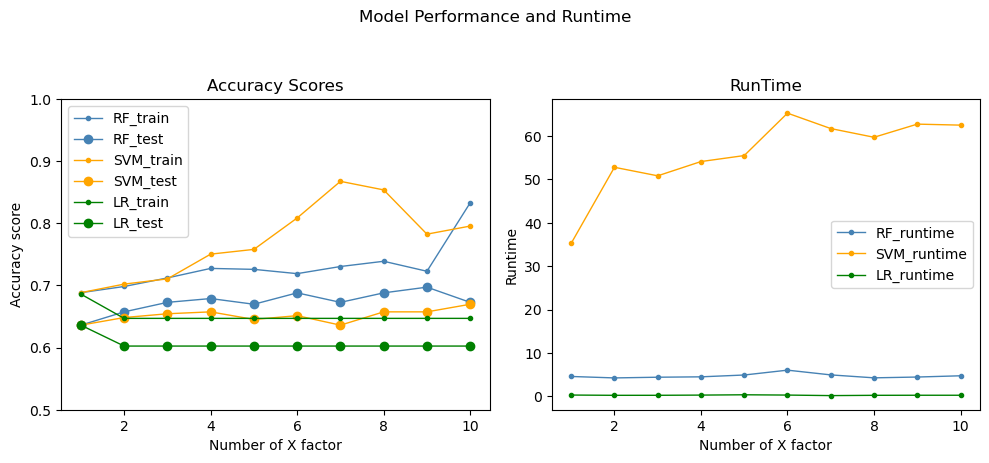

In [19]:
# Plot

n_factor = range(1,11)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Performance and Runtime")

# Plot accuracy scores
ax[0, 0].set_title("Accuracy Scores")
ax[0, 0].set_xlabel("Number of X factor")
ax[0, 0].set_ylabel("Accuracy score")
ax[0, 0].set_ylim(0.5, 1.0)
ax[0, 0].plot(n_factor, accuracy_score_Random_train[:10], marker=".", color="steelblue", lw=1, label="RF_train")
ax[0, 0].plot(n_factor, accuracy_score_Random_test[:10], marker="o", color="steelblue", lw=1, label="RF_test")
ax[0, 0].plot(n_factor, accuracy_score_SVM_train, marker=".", color="orange", lw=1, label="SVM_train")
ax[0, 0].plot(n_factor, accuracy_score_SVM_test, marker="o", color="orange", lw=1, label="SVM_test")
ax[0, 0].plot(n_factor, accuracy_score_Logi_train, marker=".", color="green", lw=1, label="LR_train")
ax[0, 0].plot(n_factor, accuracy_score_Logi_test, marker="o", color="green", lw=1, label="LR_test")
ax[0, 0].legend()

# Plot runtime
ax[0, 1].set_title("RunTime")
ax[0, 1].set_xlabel("Number of X factor")
ax[0, 1].set_ylabel("Runtime")
ax[0, 1].plot(n_factor, runtime_Random[:10], marker=".", color="steelblue", lw=1, label="RF_runtime")
ax[0, 1].plot(n_factor, runtime_SVM, marker=".", color="orange", lw=1, label="SVM_runtime")
ax[0, 1].plot(n_factor, runtime_Logi, marker=".", color="green", lw=1, label="LR_runtime")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Result and Analysis of part1
From the above graph, the following points can be read：<br>
・1）The more variables are added to the random forest, the more the accuracy scores improves for both train and test data.<br>
・2）SVM and logistic regression do not show as much improvement in accuracy score with the addition of variables.<br>
・3）Run time of SVM is much longer than other models.

## Part2（Supervised Learning Model - Random Forest Model Extension）
The number of variables in the random forest was further increased, up to 20, to check the accuracy score variation for each additional variable.<br>
-> Hyperparameter tuning was also performed using GridSearch and cross-validation.

In [20]:
for i in range(10,20):
    
  # Setting data
    df3 = df_original2[columns2[i]] 
    print('X factor:', df3.columns.values)  
    train_set, test_set = train_test_split(df3, test_size=0.2, random_state = 0)
    X_train = train_set.drop('Quality of Life_High', axis=1)
    y_train = train_set['Quality of Life_High']
    X_test = test_set.drop('Quality of Life_High', axis=1)
    y_test = test_set['Quality of Life_High']

  # Randomforest
    t1 = time.time()
    warnings.simplefilter('ignore')
    params = {'max_depth':[2 ** i for i in range(-5, 6)],
              'n_estimators':[2 ** i for i in range(-5, 6)],}
    clf = RandomForestClassifier()
    grid = GridSearchCV( clf, params, cv = 5 )
    grid.fit(X_train, y_train) 
    #print(grid.best_params_)
    best = grid.best_estimator_
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    accuracy_score_Random_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_score_Random_test.append(accuracy_score(y_test, y_test_pred))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_Random.append(elapsed_time)
    print('Accuracy score(Randomforest): %.2f, Test: %.2f' % (
            accuracy_score(y_train, y_train_pred), 
            accuracy_score(y_test, y_test_pred)    
          ))
    print('-'*80)
    

X factor: ['Comunication Problem' 'Income_new' 'Interpretation (Medical)'
 'Satisfaction With Housing.' 'Education Completed' 'Family Pride'
 'Place to Live' 'Preferance' 'Achieving Ends Meet' 'Place to Work'
 'Regular Exercise' 'Quality of Life_High']
Accuracy score(Randomforest): 0.73, Test: 0.67
--------------------------------------------------------------------------------
X factor: ['Comunication Problem' 'Income_new' 'Interpretation (Medical)'
 'Satisfaction With Housing.' 'Education Completed' 'Family Pride'
 'Place to Live' 'Preferance' 'Achieving Ends Meet' 'Place to Work'
 'Regular Exercise' 'See Friends' 'Quality of Life_High']
Accuracy score(Randomforest): 0.87, Test: 0.73
--------------------------------------------------------------------------------
X factor: ['Comunication Problem' 'Income_new' 'Interpretation (Medical)'
 'Satisfaction With Housing.' 'Education Completed' 'Family Pride'
 'Place to Live' 'Preferance' 'Achieving Ends Meet' 'Place to Work'
 'Regular Exerc

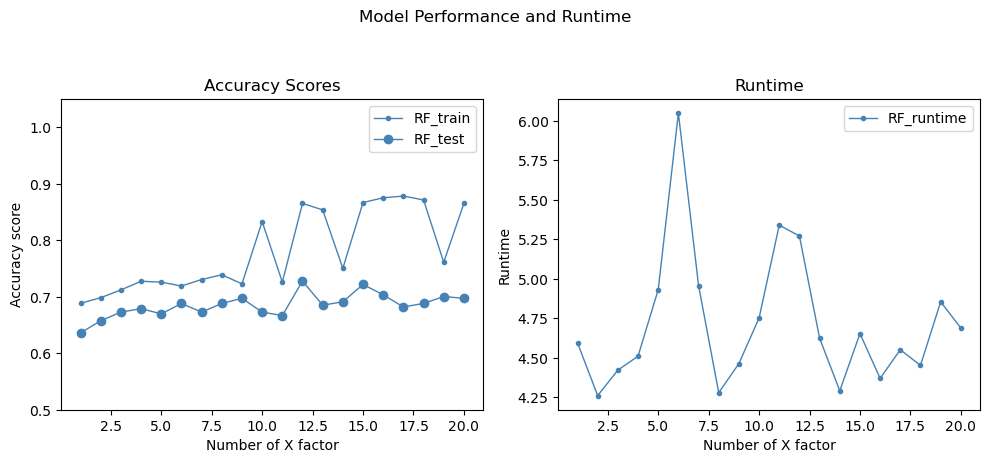

In [21]:
# Plot

n_factor = range(1,21)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Performance and Runtime")

# Plot accuracy scores
ax[0, 0].set_title("Accuracy Scores")
ax[0, 0].set_xlabel("Number of X factor")
ax[0, 0].set_ylabel("Accuracy score")
ax[0, 0].set_ylim(0.5, 1.05)
ax[0, 0].plot(n_factor, accuracy_score_Random_train, marker=".", color="steelblue", lw=1, label="RF_train")
ax[0, 0].plot(n_factor, accuracy_score_Random_test, marker="o", color="steelblue", lw=1, label="RF_test")
ax[0, 0].legend()

# Plot runtime
ax[0, 1].set_title("Runtime")
ax[0, 1].set_xlabel("Number of X factor")
ax[0, 1].set_ylabel("Runtime")
ax[0, 1].plot(n_factor, runtime_Random, marker=".", color="steelblue", lw=1, label="RF_runtime")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Result and Analysis of part2
From the above graph, following points can be read：<br>
・1）The addition of variables to random forests model did not always improve the accuracy score of the test data.<br>
・2）On the other hand, the accuracy score of he train data grew as more variables were added, but this was not the case for the test data. This means that overfitting happend.<br>

## Part3（Unsupervised Learning model - Multiple Model Comparison）
Two types of models were created as unsupervised learning :<br>
・1）NMF（Nonnegative Matrix Factorization）<br>
・2）Clustering<br>
-> Hyperparameter tuning was also performed using GridSearch and cross-validation.<br>
-> Models were also created for each of the cases where the number of variables with high correlation coefficient ranged from 1 to all features to check the behavior of the accuracy score variation.

In [22]:
# NMF Function

def get_max_accuracy(y_true, y_pred):
   
    y_pred = np.argmax(y_pred, axis = 1)
    l = np.unique(y_true)
    t = y_true.values
    mx = 0
    mx = max(np.mean(y_pred == t), np.mean(y_pred != t))
    
    return mx


class NMF_custom(BaseEstimator, ClassifierMixin):
   
    def __init__(self, n_components = 2, init = None, l1_ratio = 0, max_iter = 200):
    # Components is set to 2 because the number of categories to predict is 2
        self.n_components = n_components
        self.init = init
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        
    def fit(self, X, y=None):
        self.nmf = NMF(n_components = self.n_components, init = self.init, l1_ratio = self.l1_ratio, max_iter = self.max_iter)
        self.nmf.fit(X)
        return self
    
    def predict(self, X):
        return self.nmf.transform(X)


In [23]:
# Clustering Function

def get_max_accuracy2(y_true, y_pred):
   
    l = np.unique(y_true)
    t = y_true.values
    mx = 0
    mx = max(np.mean(y_pred == t), np.mean(y_pred != t))
    
    return mx


class Clustering_custom(BaseEstimator, ClassifierMixin):
   
    def __init__(self, n_components = 2, init = None, affinity = 'euclidean', linkage = 'complete'):
        self.n_components = n_components
        self.init = init
        self.affinity = affinity
        self.linkage = linkage
        
    def fit(self, X, y=None):
        self.model = AgglomerativeClustering(n_clusters = self.n_components, affinity = self.affinity, linkage = self.linkage)
        return self

    def predict(self, X):
        return self.model.fit_predict(X)


In [24]:
# Setting data
columns3 = [[] for i in range(count)]

for i in range(2,count):
    for j in range(0,count):
        if j >= i-2:
            columns3[j].append(r[i][1])

for j in range(0,count):
    columns3[j].append( 'Quality of Life_High')

In [25]:
accuracy_score_NMF_test = []
accuracy_score_Clustering_test = []
runtime_NMF = []
runtime_Clustering = []

for i in range(0,count):
    
  # Setting data
    df3 = df[columns3[i]] # df has already transformed by LabelEncoder() 
    #print('X factor:', df3.columns.values)  
    train_set, test_set = train_test_split(df3, test_size=0.2, random_state = 0)
    X_train = train_set.drop('Quality of Life_High', axis=1)
    y_train = train_set['Quality of Life_High']
    X_test = test_set.drop('Quality of Life_High', axis=1)
    y_test = test_set['Quality of Life_High']
    
  # NMF
    t1 = time.time()
    warnings.simplefilter('ignore')
    n_unq_cat = 2 # Number of unique categories
    params = {'n_components': [n_unq_cat],'init': ['random', 'nndsvda'],'l1_ratio': [0.0, 0.5, 1.0],'max_iter': [200, 400, 600]}
    grid = GridSearchCV(estimator = NMF_custom(), param_grid = params, scoring = make_scorer(get_max_accuracy),cv = 5)
    grid = grid.fit(X_test, y_test) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    test = grid.cv_results_['mean_test_score']
    accuracy_score_NMF_test.append(max(test))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_NMF.append(elapsed_time)
    
  # Clustering
    t1 = time.time()
    params = {'affinity' : ['euclidean', 'manhattan', 'cosine'],'linkage' : ['complete', 'average', 'single'] }
    grid = GridSearchCV(estimator = Clustering_custom(), param_grid = params, scoring = make_scorer(get_max_accuracy2),cv = 5)
    grid = grid.fit(X_test, y_test) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    test = grid.cv_results_['mean_test_score']
    accuracy_score_Clustering_test.append(max(test))
    t2 = time.time()
    elapsed_time = t2-t1
    runtime_Clustering.append(elapsed_time)


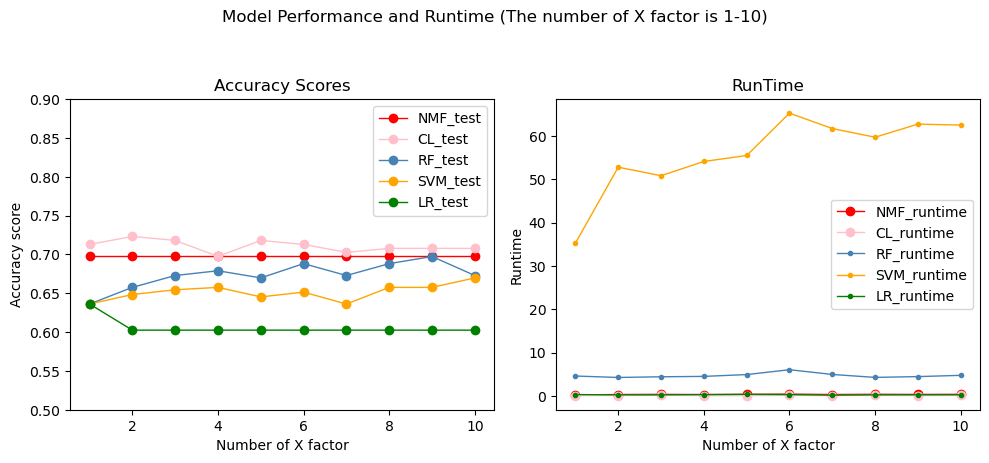

---------------------------------------------------------------------------------------------------------------------------------------


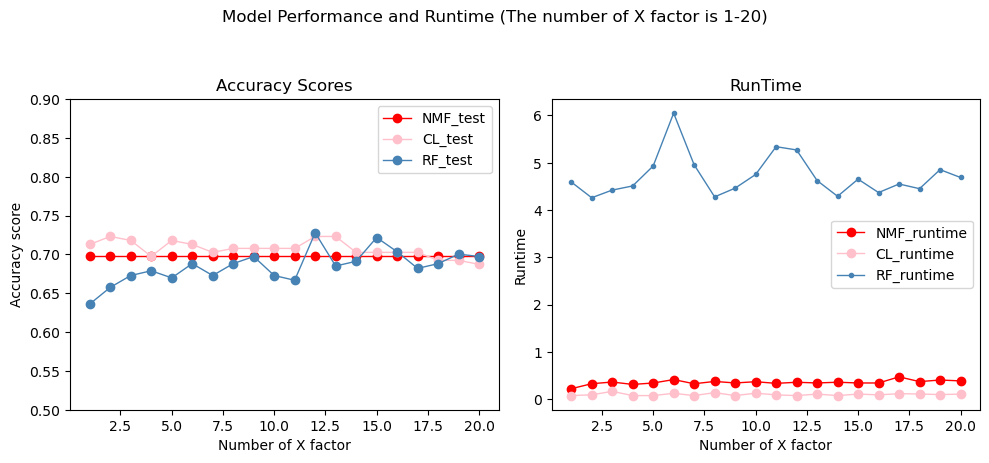

---------------------------------------------------------------------------------------------------------------------------------------


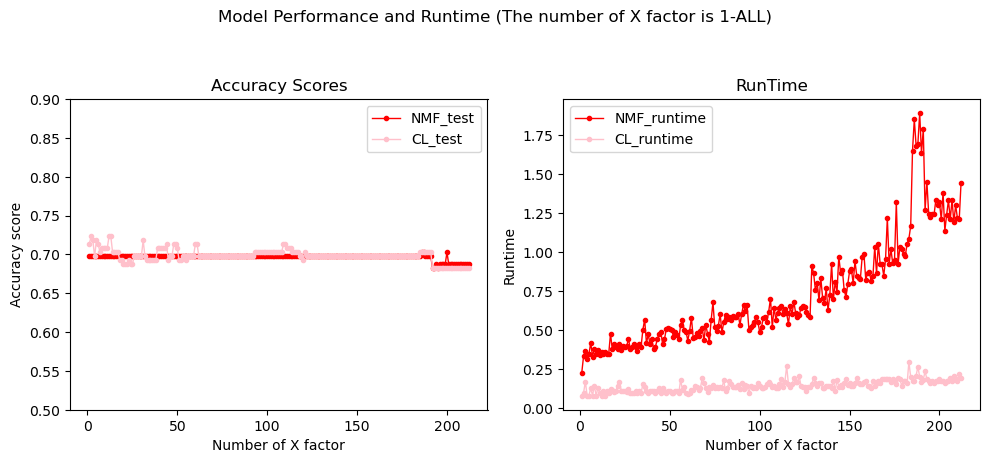

In [26]:
# Plot

n_factor = range(1,11)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Performance and Runtime (The number of X factor is 1-10)")

# Plot accuracy scores
ax[0, 0].set_title("Accuracy Scores")
ax[0, 0].set_xlabel("Number of X factor")
ax[0, 0].set_ylabel("Accuracy score")
ax[0, 0].set_ylim(0.5, 0.9)
ax[0, 0].plot(n_factor, accuracy_score_NMF_test[:10], marker="o", color="red", lw=1, label="NMF_test")
ax[0, 0].plot(n_factor, accuracy_score_Clustering_test[:10], marker="o", color="pink", lw=1, label="CL_test")
ax[0, 0].plot(n_factor, accuracy_score_Random_test[:10], marker="o", color="steelblue", lw=1, label="RF_test")
ax[0, 0].plot(n_factor, accuracy_score_SVM_test, marker="o", color="orange", lw=1, label="SVM_test")
ax[0, 0].plot(n_factor, accuracy_score_Logi_test, marker="o", color="green", lw=1, label="LR_test")
ax[0, 0].legend()

# Plot runtime
ax[0, 1].set_title("RunTime")
ax[0, 1].set_xlabel("Number of X factor")
ax[0, 1].set_ylabel("Runtime")
ax[0, 1].plot(n_factor, runtime_NMF[:10], marker="o", color="red", lw=1, label="NMF_runtime")
ax[0, 1].plot(n_factor, runtime_Clustering[:10], marker="o", color="pink", lw=1, label="CL_runtime")
ax[0, 1].plot(n_factor, runtime_Random[:10], marker=".", color="steelblue", lw=1, label="RF_runtime")
ax[0, 1].plot(n_factor, runtime_SVM, marker=".", color="orange", lw=1, label="SVM_runtime")
ax[0, 1].plot(n_factor, runtime_Logi, marker=".", color="green", lw=1, label="LR_runtime")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("-"*135)


# Plot2

n_factor = range(1,21)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Performance and Runtime (The number of X factor is 1-20)")

# Plot accuracy scores
ax[0, 0].set_title("Accuracy Scores")
ax[0, 0].set_xlabel("Number of X factor")
ax[0, 0].set_ylabel("Accuracy score")
ax[0, 0].set_ylim(0.5, 0.9)
ax[0, 0].plot(n_factor, accuracy_score_NMF_test[:20], marker="o", color="red", lw=1, label="NMF_test")
ax[0, 0].plot(n_factor, accuracy_score_Clustering_test[:20], marker="o", color="pink", lw=1, label="CL_test")
ax[0, 0].plot(n_factor, accuracy_score_Random_test[:20], marker="o", color="steelblue", lw=1, label="RF_test")
ax[0, 0].legend()

# Plot runtime
ax[0, 1].set_title("RunTime")
ax[0, 1].set_xlabel("Number of X factor")
ax[0, 1].set_ylabel("Runtime")
ax[0, 1].plot(n_factor, runtime_NMF[:20], marker="o", color="red", lw=1, label="NMF_runtime")
ax[0, 1].plot(n_factor, runtime_Clustering[:20], marker="o", color="pink", lw=1, label="CL_runtime")
ax[0, 1].plot(n_factor, runtime_Random[:20], marker=".", color="steelblue", lw=1, label="RF_runtime")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("-"*135)


# Plot3

n_factor = range(1,count+1)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Performance and Runtime (The number of X factor is 1-ALL)")

# Plot accuracy scores
ax[0, 0].set_title("Accuracy Scores")
ax[0, 0].set_xlabel("Number of X factor")
ax[0, 0].set_ylabel("Accuracy score")
ax[0, 0].set_ylim(0.5, 0.9)
ax[0, 0].plot(n_factor, accuracy_score_NMF_test, marker=".", color="red", lw=1, label="NMF_test")
ax[0, 0].plot(n_factor, accuracy_score_Clustering_test, marker=".", color="pink", lw=1, label="CL_test")
ax[0, 0].legend()

# Plot runtime
ax[0, 1].set_title("RunTime")
ax[0, 1].set_xlabel("Number of X factor")
ax[0, 1].set_ylabel("Runtime")
ax[0, 1].plot(n_factor, runtime_NMF, marker=".", color="red", lw=1, label="NMF_runtime")
ax[0, 1].plot(n_factor, runtime_Clustering, marker=".", color="pink", lw=1, label="CL_runtime")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Summary of part3
From the above graph, following points can be read：<br>
・1）NMF and clustering model resulted in higher accuracy than supervised learning models such as Random Forest, SVM, Logistic regression.<br>
・2）On the other hand, even when features were added, the accuracy of NMF and clustering did not improve and remained almost unchanged.
.<br>
・3) In terms of runtime, NMF and clustering model outperformed supervised learning models. In addition, runtime of NMF increased slightly as the number of features was increased, while clustering result was stable in a small time.<br>
-> Because of the large number of features and small amount of training data, unsupervised learning models seems to have better accuracy and shorter rumtime.

# Discussion and Conclusion

## Conclusion
According to the correlation coefficients, the following items have a significant impact on the quality of life of Asian Americans:<br>
・1）Comunication Problem<br>
・2）Income_new<br>
・3）Interpretaion(Medical)<br>
<br>
Unsupervised learning models outperformed supervised learning models in terms of both accuracy and run time. Especially, clustering model was the most suitable predictive model. The runtime of clustering model was satisfactory. However,the accuracy was only about 70%, which was far from satisfactory.

## Discussion
The following is a possible reason why the accuracy score of the model was not as high as expected:<br>
・The original data is about 2600, and after deleting the rows containing Nan-value, the total number of train and test data is lower than that , which is insufficient for the number of samples.<br>
-> If additional data can be collected, the model is expected to become more accurate.<br>
<br>
I initially attempted to create a model to predict the quality of life itself (0-10), but the accuracy score was too low due to the small sample size, etc. Therefore, I decided to adopt a binary classification problem so that it could be handled even with a small sample.

In [27]:
df2.to_csv(r'df2.csv')